In [33]:
#import Spark and MLlib packages
from pyspark import SparkContext, SparkConf
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import GaussianMixture
from math import sqrt, fabs

#import data analysis packages
import numpy as np
import pandas as pd
import sklearn
import itertools

from scipy import linalg
from pandas import Series, DataFrame
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.datasets import load_files
from numpy import array

from sklearn import tree
from sklearn.mixture import GMM

#import data visualization packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from matplotlib.colors import LogNorm

#misc packages
from __future__ import division
from __future__ import print_function

In [2]:
#I.Read the MLlib sample data
#notice, you have to set dtype to None to let numpy automatically guess data type
X_train = np.genfromtxt('/usr/local/spark/data/mllib/gmm/gmm_data.txt', delimiter=' ', dtype=None)

In [3]:
X_train

array([[ 2.59470454,  2.12298217],
       [ 1.15807024, -0.14649872],
       [ 2.46206638,  0.61955689],
       ..., 
       [-1.19871928,  0.98242915],
       [-2.53040133,  2.10671307],
       [-1.94085605,  1.38938137]])

In [24]:
# Train a Gaussian Mixture Model with two components
clf = GMM(n_components=2, covariance_type='full')
clf.fit(X_train)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=0.01)

In [43]:
# Get the model return's parameters
for i in range(2):
    print ("\nweight = ", clf.weights_[i], "\nmu = ", clf.means_, 
           "\nsigma = ", clf.covars_[i])


weight =  0.518534951053 
mu =  [[-0.10473428  0.04294268]
 [ 0.07217039  0.01664446]] 
sigma =  [[ 4.91470467 -2.00982282]
 [-2.00982282  1.01376095]]

weight =  0.481465048947 
mu =  [[-0.10473428  0.04294268]
 [ 0.07217039  0.01664446]] 
sigma =  [[ 4.7738055   1.87216891]
 [ 1.87216891  0.91442926]]


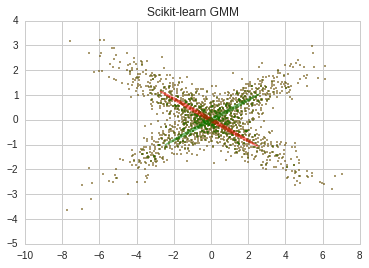

In [58]:
color_iter = itertools.cycle(['r','g'])
splot = plt.subplot(1, 1, 1)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf._get_covars(), color_iter)):
    v, w =linalg.eigh(covar)
    u = w[0]/linalg.norm(w[0])
    
    plt.scatter(X_train[:, 0], X_train[:, 1], .8, color=color)
    angle = np.arctan(u[1]/u[0])
    angle = 180*angle/np.pi
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180+angle, color = color)
    ell.set_clip_box(plt.box)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    
plt.title("Scikit-learn GMM")

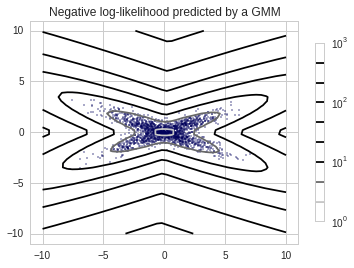

In [64]:
# display predicted scores by the model as a contour plot
x = np.linspace(-10.0, 10.0)
y = np.linspace(-10.0, 10.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [7]:
#IV Use MLlib
sc = SparkContext("local", "GMM")

In [8]:
data = sc.textFile('/usr/local/spark/data/mllib/gmm_data.txt')

In [9]:
#Split the training set and test set
parsedData = data.map(lambda line: array([float(x) for x in line.strip().split(' ')]))

In [17]:
# Build the model (cluster the data)
#K-number of Gaussian Models
K=2 
gmm = GaussianMixture.train(parsedData, K)

In [23]:
#Get the output parameters of the model
#weights--weight for each Gaussian Model
#mu--means
#sigma--covariances metrix
for i in range(K):
    gmm_mean 
    print ("\nweight = ", gmm.weights[i], "\nmu = ", gmm.gaussians[i].mu, 
           "\nsigma = ", gmm.gaussians[i].sigma.toArray())


weight =  0.480544355411 
mu =  [0.072210123178,0.0166815536964] 
sigma =  [[ 4.7797989   1.87626753]
 [ 1.87626753  0.91468018]]

weight =  0.519455644589 
mu =  [-0.104457487115,0.0428617539109] 
sigma =  [[ 4.90702779 -2.00674724]
 [-2.00674724  1.0114307 ]]


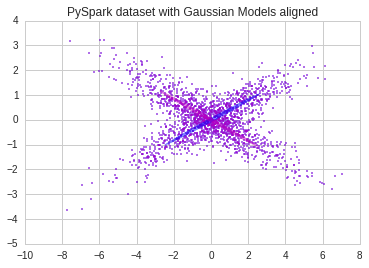

In [57]:
color_iter = ['b','m']
splot = plt.subplot(111)
for i in range(2):
    mean = gmm.gaussians[i].mu
    covar = gmm.gaussians[i].sigma.toArray()
    color = color_iter[i]
    v, w =linalg.eigh(covar)
    u = w[0]/linalg.norm(w[0])
    
    plt.scatter(X_train[:, 0], X_train[:, 1], .8, color=color)
    angle = np.arctan(u[1]/u[0])
    angle = 180*angle/np.pi
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180+angle, color = color)
    ell.set_clip_box(plt.box)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    
plt.title("PySpark dataset with Gaussian Models aligned")